In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from scipy.signal import savgol_filter as savgol
import seaborn as sb
import pandas as pd
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
import os
import sys
from regions import get_interregions, get_promoterregions

In [2]:
class Datatable:
    def __init__(self,datadict,fasta_path,genbank_path):
        '''This class is an all-in-one function to 1) extract dictionary keys from run outputs 
        and 2) prepare necessary information for promoter region mining. For 2), we need both the
        cds_from_genome.fasta as well as the .gbff as datadict's IDs are only found in the fasta 
        but the fasta is extremely unparseable (too many edge cases). The genbank file comes in handy
        to extract descriptive gene info after identifying which features to keep using the fasta. '''
        
        # assign all the dictionary keys that came from the output of optimal_sensors run
        self.reps = datadict['reps'] # list of replicates used 
        self.ntimepts = datadict['ntimepts'] # original number of timepoints in dataset i.e. before subsetting for parameter fitting
        self.X = datadict['X'] # dataset used to fit model parameters
        self.newntimepts = datadict['newntimepts'] # number of timepoints in dataset used to fit model parameters
        self.transcriptIDs = datadict['transcriptIDs'] # all transcriptIDs of original dataset
        self.keepers = datadict['keepers'] # indices of genes kept for parameter fitting
        self.keep_transcriptIDs = [self.transcriptIDs[i] for i in self.keepers] # transcriptIDs corresponding to used dataset
        self.A = datadict['A'] # learned model
        self.cd = datadict['cd'] # R^2 obtained over n-step prediction
        self.percent_nonzero_to_zero = datadict['percent_nonzero_to_zero'] # percent of nonzero elements that were set to zero during sparsification
        self.C = datadict['C'] # observer matrix
        self.opt_horizon = datadict['opt_horizon'] # horizon for optimization to obtain observer matrix
        self.sparseThresh = datadict['sparseThresh'] # mod of all elements of A less than sparseThresh were set to 0
        self.filter_method = datadict['filter_method'] # the method used for gene downselection 
        self.filterBeforeBS = datadict['filterBeforeBS'] # 'True' if downselection was done before background subtraction
        self.norm = datadict['norm'] # 'True' if the data was normalized
        
        # get records of the genes that we have kept for analysis
        # have to use cds_from_genome.fasta because this is the where the transcriptIDs came from (e.g. lcl|AM181176.4_cds_CAY53368.1_5775)
        self.fasta_records = list(SeqIO.parse(fasta_path,'fasta')) # full cds_from_genome fasta
        self.keep_fasta_records = [] # getting records of genes that we have used
        for tx in self.keep_transcriptIDs:
            for rec in self.fasta_records:
                if rec.name == tx:
                    self.keep_fasta_records.append(rec)
                    
        # match locus_tags in keep_records (from fasta) with tags in genbank to easily parse rest of cds' description 
        # can grab gene names and tags from the fasta description, other info need to grab from the genbank
        self.genes, self.locus_tags = [],[] 
        for rec in self.keep_fasta_records:
            rec_elems = [x.strip().strip(']') for x in rec.description.split(' [')]
            if 'gene=' in str(rec_elems): # sequence has gene name (e.g. gene=dnaA)
                self.genes.append(rec_elems[1][5:])
                self.locus_tags.append(rec_elems[2][10:])
            elif 'gene=' not in str(rec_elems): # sequence has no gene name, but has locus tag
                self.genes.append('N/A')
                self.locus_tags.append(rec_elems[1][10:])
        
        # now map the locus_tags to corresponding features in genbank, grab feature's proteins, locations, and strandedness
        gb_records = next(SeqIO.parse(genbank_path,'genbank'))
        self.proteins,self.locations = [],[] # each element of locations will be of length 3, 0:start,1:end,2:strand
        for tag in self.locus_tags:
            for feature in gb_records.features:
                if feature.type == 'CDS':
                    if feature.qualifiers['locus_tag'][0] == tag: 
                        self.proteins.append(feature.qualifiers['product'][0])
                        if feature.strand == 1: # 5' -> 3'
                            self.locations.append([feature.location.start.position,feature.location.end.position,1])
                        elif feature.strand == -1: # 3' -> 5' (complementary)
                            self.locations.append([feature.location.start.position,feature.location.end.position,-1])            
        
        # sort C in ascending order and get corresponding inds to sort other lists
        # recall that C is a 1xN dimensional vector that contains the observability score for each gene
        self.sorted_inds = self.C[:,0].argsort() # getting indices of C in ascending order
        self.sorted_C = self.C[self.sorted_inds] # sort C in ascnding order 
        self.sorted_transcriptIDs = [self.keep_transcriptIDs[i] for i in self.sorted_inds]
        self.sorted_genes = [self.genes[i] for i in self.sorted_inds]
        self.sorted_locus_tags = [self.locus_tags[i] for i in self.sorted_inds]
        self.sorted_proteins = [self.proteins[i] for i in self.sorted_inds]
        self.sorted_locations = [self.locations[i] for i in self.sorted_inds]

In [56]:
data_dir = 'data/'
results_dir = 'run-outputs/'
genbank_path = data_dir+'GCA_000009225.1_ASM922v1_genomic.gbff'
cdsFasta_path = data_dir+'GCA_000009225.1_ASM922v1_cds_from_genomic.fa'

# data0 = Datatable(pickle.load(open(results_dir+'dump012_filterB4BS_DTW_IC0_m8.pickle','rb')),cdsFasta_path,genbank_path)
# data1 = Datatable(pickle.load(open(results_dir+'dump012_filterAfterBS_DTW_IC0_m8.pickle','rb')),cdsFasta_path,genbank_path)
# data2 = Datatable(pickle.load(open(results_dir+'dump012_sparse0.003_filterB4BS_DTW_IC0_m8.pickle','rb')),cdsFasta_path,genbank_path)
# data3 = Datatable(pickle.load(open(results_dir+'dump012_sparse0.003_reduced_filterB4BS_DTW_IC0_m8.pickle','rb')),cdsFasta_path,genbank_path)
# data4 = Datatable(pickle.load(open(results_dir+'dump01_sparse0.003_reduced_filterB4BS_DTW_IC0_m8.pickle','rb')),cdsFasta_path,genbank_path)
data5 = Datatable(pickle.load(open(results_dir+'dump02_sparse0.003_reduced_filterB4BS_DTW_IC0_m8.pickle','rb')),cdsFasta_path,genbank_path)

In [4]:
def plot_gene_traces(data,k,start='0',pltdim=(10,10),savedir='figures/',savefig=False,showfig=False):
    '''data is a Datatable object. k is the number of genes to plot and
    pltdim should be (sqrt(k),sqrt(k))'''
    
    if start=='-1':
        X = data.X[data.sorted_inds[-k:]]
        genes = data.sorted_genes[-k:]
        tags = data.sorted_locus_tags[-k:]
    else:
        X = data.X[data.sorted_inds[0:k]]
        genes = data.sorted_genes[0:k]
        tags = data.sorted_locus_tags[0:k]
    nreps = len(data.reps)
    tspan = np.linspace(20,100,X.shape[1])
    fig, axs = plt.subplots(pltdim[0], pltdim[1], figsize=(12,10));
    mt =  ['o--','d--','p--']
    repname = ['R1','R2','R3']
    colors = ['tab:blue','tab:orange','tab:green']
    count = 0
    for ax in axs.reshape(-1):
        ymin,ymax = np.min(X[count])-25,np.max(X[count])+25
        for rr in range(0,nreps): 
            ax.plot(tspan,savgol(X[count,:,rr],5,3),mt[rr],lw=2,ms=5,color=colors[rr],label=repname[rr]);
            # add gene names or locus tags to subplot title
            if genes[count] == 'N/A':
                ax.set_title(tags[count],fontsize=12)
            else:
                ax.set_title(genes[count],fontsize=12)
        # Hide the right and top spines and make bottom and left axes thicker
        for axis in ['right','top']:
            ax.spines[axis].set_visible(False)
        for axis in ['bottom','left']:
            ax.spines[axis].set_linewidth(1.2)
        # increase ticklabel fontsizes
        ax.tick_params(axis='both', which='major', labelsize=12)
        ax.set_ylim([ymin,ymax])
        count+=1
        
    axs[-1,-1].legend(repname,bbox_to_anchor=(1.05, 1),loc='upper left',markerscale=2,fontsize=12,shadow=True)
    
    # Set common labels
    fig.text(0.5, -0.01, r'$Time \; (minutes)$', ha='center', va='center',fontsize=20)
    fig.text(-0.04, 0.5, r'$TPM_{BS}$', ha='center', va='center', rotation='vertical',fontsize=22)
        
    plt.tight_layout();
    if savefig:
        plt.savefig(savedir)
    if not showfig:
        plt.close()

def plot_eigvals(matrix):
    theta = np.linspace(0,20,100)
    L = np.linalg.eigvals(matrix)
    plt.figure();
    plt.plot(np.real(L),np.imag(L),'o');
    plt.plot(np.cos(theta),np.sin(theta),color='black',alpha=0.3)
    plt.axis('equal');

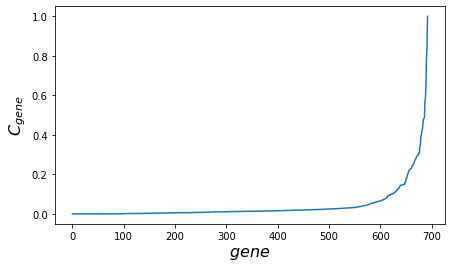

In [57]:
plt.figure(figsize=(7,4));
plt.plot(data5.sorted_C);
plt.ylabel(r'$C_{gene}$',fontsize=16);
plt.xlabel(r'$gene$',fontsize=16);


In [67]:
len(list(set(data3.sorted_locus_tags[-k:])&set(data5.sorted_locus_tags[-k:])))

46

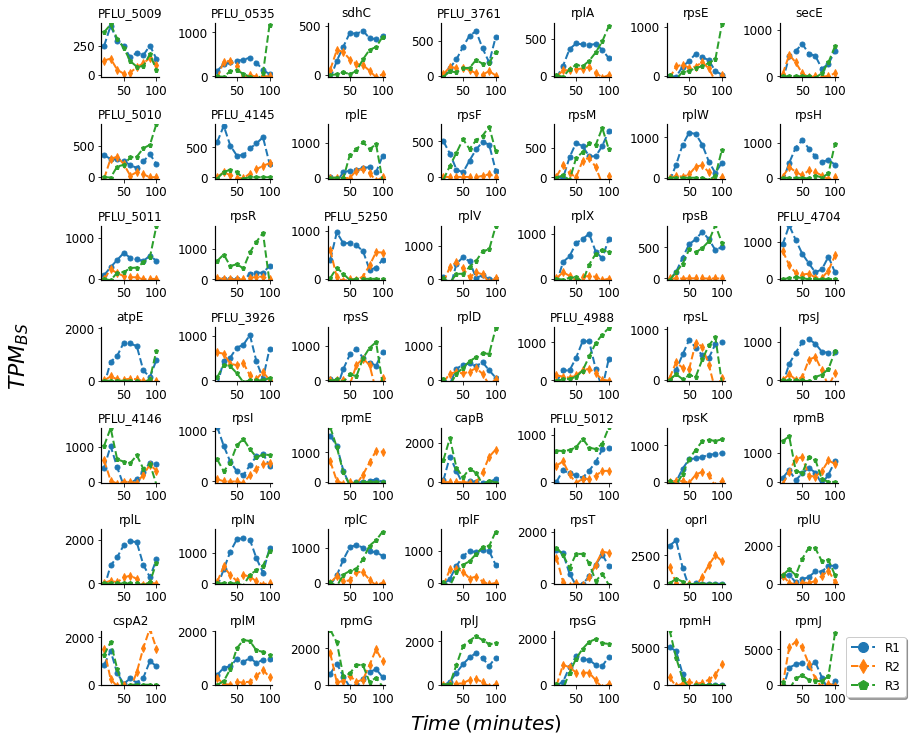

In [59]:
k = 49
save_dir = 'figures/data3_top50.pdf'
plot_gene_traces(data3,k,pltdim=(7,7),start='-1',savedir=save_dir,savefig=False,showfig=True)




#### Get the intergenic regions (or putative promoter regions) from the genbank (gbff) file

In [7]:
intergenic_records = get_interregions(genbank_path,intergene_length=50)
# Q: What should be the minimum intergene_length? 

doWrite = False
if doWrite:
    outpath = os.path.splitext(os.path.basename(genbank_path))[0] + "_ign.fa"
    SeqIO.write(intergenic_records, open('data/'+outpath, 'w'), 'fasta');

#### Given the gene's location, output the nearest promoter region. 

In [8]:
# get promoter sequences for the given genes of interest (the genes depend on the model)
promoter_records = get_promoterregions(data3,intergenic_records,genbank_path,rel_dist_thresh=5000)

doWrite = False
if doWrite:
    outpath = os.path.splitext(os.path.basename(genbank_path))[0] + "_promoters.fa"
    SeqIO.write(promoter_records, open('data/'+outpath, 'w'), 'fasta');

In [9]:
# compare promoter_records.id to data.locus_tags 
promoter_seqs = []
for i,record in enumerate(promoter_records):
    print(record.id, data3.locus_tags[i])
    promoter_seqs.append(str(record.seq))

PFLU_0001_0 PFLU_0001
PFLU_0002_1 PFLU_0002
PFLU_5881_2 PFLU_5881
PFLU_0004_3 PFLU_0004
PFLU_5886_4 PFLU_5886
PFLU_0009_5 PFLU_0009
PFLU_0010_6 PFLU_0010
PFLU_0011_7 PFLU_0011
PFLU_2991_8 PFLU_2991
PFLU_2993_9 PFLU_2993
PFLU_0018_10 PFLU_0018
PFLU_5900_11 PFLU_5900
PFLU_5901_12 PFLU_5901
PFLU_5944_13 PFLU_5944
PFLU_5946_14 PFLU_5946
PFLU_5950_15 PFLU_5950
PFLU_5951_16 PFLU_5951
PFLU_5953_17 PFLU_5953
PFLU_0080_18 PFLU_0080
PFLU_0081_19 PFLU_0081
PFLU_5979_20 PFLU_5979
PFLU_5980_21 PFLU_5980
PFLU_0109_22 PFLU_0109
PFLU_5989_23 PFLU_5989
PFLU_5991_24 PFLU_5991
PFLU_5993_25 PFLU_5993
PFLU_5994_26 PFLU_5994
PFLU_5995_27 PFLU_5995
PFLU_5996_28 PFLU_5996
PFLU_5997_29 PFLU_5997
PFLU_6021_30 PFLU_6021
PFLU_3236_31 PFLU_3236
PFLU_6034_32 PFLU_6034
PFLU_6055_33 PFLU_6055
PFLU_6058_34 PFLU_6058
PFLU_6071_35 PFLU_6071
PFLU_6076_36 PFLU_6076
PFLU_6077_37 PFLU_6077
PFLU_0265_38 PFLU_0265
PFLU_0266_39 PFLU_0266
PFLU_0267_40 PFLU_0267
PFLU_6117_41 PFLU_6117
PFLU_6118_42 PFLU_6118
PFLU_6119_43 PFLU_611

In [10]:
# How many unique promoter sequences are there compared to the number of genes?
len(set(promoter_seqs)), len(data3.locus_tags)

(323, 506)

In [11]:
seq_lens = []
for seq in list(set(promoter_seqs)):
    seq_lens.append(len(seq))

In [12]:
a = [x for x in seq_lens if x<=300] 
len(a)

255

In [13]:
sorted_seqs = [promoter_seqs[i] for i in data3.sorted_inds]
sorted_seqs

['CGCTTCGCTGAATTGCGAATCTGCCGCATTTTGCGGCAGTTTGTTTATTGCCAGTTGGAATAAGAAAGGACTTC',
 'GCACCTCGTGCCTGCTTATGTAGGTAATTAGGAATTGATTGGTTGAGCTGGTTTTAGAGCTTTGGCGGCAAGTATAGGGACTTAGCCCTTCCTAAAGAACCCTTTGCACAAAATTTAACCAGCTGTGGATGAATCACAGACAATAGAAATTAAAAGAGAGAAATATATTAAAGCTTTGTTTTTATGTTTATTTCTACTGAACAACATTTCTGTGGATAGATCTCTACAGGCCTTAATTTACGTTGTGTACAGCGATTCAAAAGTCTGTGGTCATGTGCCAATGAGGCCGTTGGATAAGTGCGTTAAGCCTGTGGATTAAACAGGTGGTTATCCACATAGGGGTTTTTGCTCAGGTTTCAGGCCCTGTTATCAACTGGGCACAGGAGCGGTTATTCACAGGGCTTAATCCACAGAAATCAGTGAATCTGGCTGTATTCTGTCCACGACAACGCCAGCCGAAACCTTCCACTCGGTGGTGAGCACGGCAAAAAGAGATCTATTGTGAGAAAACCGCAGGACAGTTAATAATAGCGATTATCATTAACCTGCC',
 'AGATCCTCTCGCGGCGGTAATAAAGGAAGACAATTGAAAAGGGAGTGGCAGTTTAAAGCGAAGTTCCGACCACGTCACCGCTTTACGGGGGTTGGCCCCCCCTGGCGGCTGTGTATACTTACCGCCATTTTAACGCCCTGGAACCTCC',
 'GAAGATCCTCGGGTCAGGCGCGCAGGGTGCGCACAAGAAGTGTGGAAGGGTAAAAAACAAGCTGTGAGTGGATAAGTAGCTTGCTACGCAATATACTTACGTTCATGGTTGTTTGTAAACTCTTGACAGGCTTCGCGGAGTGTTGACAAAGCAACGCCCGAAGCCTCGATTCCATTACGTTCGGCACCCATGACGGTGTCGTCCCACAAAT

In [14]:
rpXgenes=[]
for i,seq in enumerate(sorted_seqs):
    if 'rpl' in data3.sorted_genes[i]:
        rpXgenes.append([data3.sorted_genes[i],i])
    elif 'rps' in data3.sorted_genes[i]:
        rpXgenes.append([data3.sorted_genes[i],i])
    elif 'rpm' in data3.sorted_genes[i]:
        rpXgenes.append([data3.sorted_genes[i],i])
    

In [15]:
len(rpXgenes)

46

In [18]:
max(seq_lens)

1470